In [1]:
%matplotlib widget
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
import vegas
import random as rand

#Lambda = 10 ** 12
alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e
ECM = m_h
hats = ECM ** 2 # all quantities are in GeV
pb_convert = 3.894E8 # conversion factor GeV^-2 -> pb
#C_eB = 10 ** (19)
#C_eW = 10 ** (19)
#C_eB_conj = C_eB
#C_eW_conj = C_eW
#C_HD = 10 ** (19)
#C_HWB = 10 ** (19)
#v_alt = v / (1 + (v ** 2 / Lambda ** 2) * (cos / sin) * (C_HWB + (cos / (4 * sin)) * C_HD))

def diff_decay(s, t, ml, v, CW, SW, C_eB, C_eW, C_eB_conj, C_eW_conj, Lambda):
    N = 1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = (4 * e ** 2 * (m_h ** 4 + s ** 2)) / (t * u)
    struc_6 = 4 * 2 ** 0.5 * e * m_h ** 2 * (-(C_eB + C_eB_conj) * CW + (C_eW + C_eW_conj) * SW) 
    struc_8 = 8 * t * u * (C_eB * CW - C_eW * SW) * (C_eB_conj * CW - C_eW_conj * SW)
    return [N * (ml / v) ** 2 * struc_4, N * (1 / Lambda ** 2) * (ml / v) * struc_6, N *(1 / Lambda ** 4) * struc_8]

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

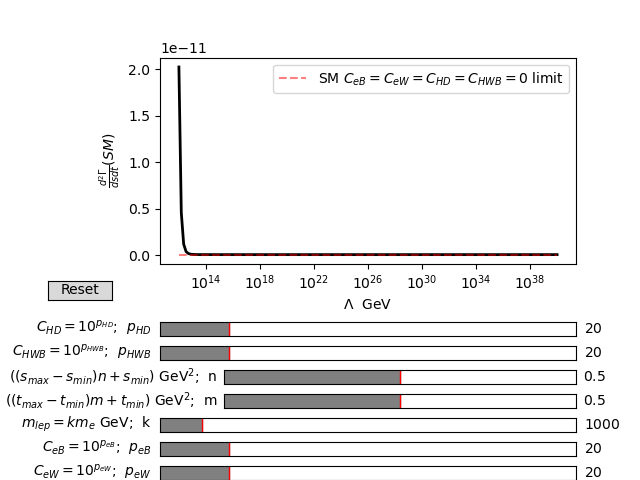

In [2]:
Lambdas = np.logspace(12,40,160)

def SM_decay(n, m, k_ml, p_HD, p_HWB, cos, sin, p_eB, p_eW, Lambdas):
    ml = k_ml * m_e
    s_min_fix = 4 * ml ** 2 
    s_max_fix = m_h ** 2 
    t_min_fix = ml ** 2
    t_max_fix = (m_h - ml) ** 2
    s_pick = (s_max_fix - s_min_fix) * n + s_min_fix
    t_pick = (t_max_fix - t_min_fix) * m + t_min_fix
    C_HWB = 10 ** p_HWB
    C_HD = 10 ** p_HD
    v_alt = v / (1 + (v ** 2 / Lambdas ** 2) * (cos / sin) * (C_HWB + (cos / (4 * sin)) * C_HD))
    C_eB = 10 ** p_eB
    C_eW = 10 ** p_eW
    C_eB_conj = C_eB
    C_eW_conj = C_eW
    return diff_decay(s_pick, t_pick, ml, v_alt, cos, sin, C_eB, C_eW, C_eB_conj, C_eW_conj, Lambdas)[0]

init_p_HD = 20
init_p_HWB = 20
init_n = 0.5
init_m = 0.5
init_k_ml = 1000
init_p_eB = 20
init_p_eW = 20

fig, ax = plt.subplots()
line, = ax.plot(Lambdas, SM_decay(init_n, init_m, init_k_ml, init_p_HD, init_p_HWB, cos, sin, init_p_eB, init_p_eW, Lambdas), lw=2, color = 'black')
line1, = ax.plot(Lambdas, SM_decay(init_n, init_m, init_k_ml, -np.inf, -np.inf, cos, sin, -np.inf, -np.inf, Lambdas), linestyle = '--', color = 'red', alpha = 0.5, label = 'SM $C_{eB}=C_{eW}=C_{HD}=C_{HWB}=0$ limit')
plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel('$\Lambda$  GeV')
ax.set_ylabel(r'$\frac{d^{2}\Gamma}{dsdt}(SM)$')
plt.legend()

fig.subplots_adjust(left=0.25, bottom=0.45)

ax_p_HD = fig.add_axes([0.25, 0.3, 0.65, 0.03])
p_HD_slider = Slider(
    ax=ax_p_HD,
    label=r'$C_{HD}=10^{p_{HD}}$;  $p_{HD}$',
    valmin=15,
    valmax=45,
    valinit=init_p_HD,
    color = 'gray')

ax_p_HWB = fig.add_axes([0.25, 0.25, 0.65, 0.03])
p_HWB_slider = Slider(
    ax=ax_p_HWB,
    label=r'$C_{HWB}=10^{p_{HWB}}$;  $p_{HWB}$',
    valmin=15,
    valmax=45,
    valinit=init_p_HWB,
    color = 'gray')

axs = fig.add_axes([0.35, 0.2, 0.55, 0.03])
n_slider = Slider(
    ax=axs,
    label=r'$((s_{max} - s_{min})n + s_{min})$ GeV$^{2}$;  n',
    valmin=0,
    valmax=1,
    valinit=init_n,
    color = 'gray')

axt = fig.add_axes([0.35, 0.15, 0.55, 0.03])
m_slider = Slider(
    ax=axt,
    label=r'$((t_{max} - t_{min})m + t_{min})$ GeV$^{2}$;  m',
    valmin=0,
    valmax=1,
    valinit=init_m,
    color = 'gray')

axml = fig.add_axes([0.25, 0.1, 0.65, 0.03])
k_ml_slider = Slider(
    ax=axml,
    label=r'$m_{lep} = k m_{e}$ GeV;  k',
    valmin=1,
    valmax=10000,
    valinit=init_k_ml,
    color = 'gray')

ax_C_eB = fig.add_axes([0.25, 0.05, 0.65, 0.03])
p_eB_slider = Slider(
    ax=ax_C_eB,
    label=r'$C_{eB} = 10^{p_{eB}}$;  $p_{eB}$',
    valmin=15,
    valmax=45,
    valinit=init_p_eB,
    color = 'gray')

ax_C_eW = fig.add_axes([0.25, 0.0, 0.65, 0.03])
p_eW_slider = Slider(
    ax=ax_C_eW,
    label=r'$C_{eW} = 10^{p_{eW}}$;  $p_{eW}$',
    valmin=15,
    valmax=45,
    valinit=init_p_eW,
    color = 'gray')

def update(val):
    line.set_ydata(SM_decay(n_slider.val, m_slider.val, k_ml_slider.val, p_HD_slider.val, p_HWB_slider.val, cos, sin, p_eB_slider.val, p_eW_slider.val, Lambdas))
    line1.set_ydata(SM_decay(n_slider.val, m_slider.val, k_ml_slider.val, -np.inf, -np.inf, cos, sin, -np.inf, -np.inf, Lambdas))
    fig.canvas.draw_idle()

p_HD_slider.on_changed(update)
p_HWB_slider.on_changed(update)
n_slider.on_changed(update)
m_slider.on_changed(update)
k_ml_slider.on_changed(update)
p_eB_slider.on_changed(update)
p_eW_slider.on_changed(update)

resetax = fig.add_axes([0.075, 0.375, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    p_HD_slider.reset()
    p_HWB_slider.reset()
    n_slider.reset()
    m_slider.reset()
    k_ml_slider.reset()
    p_eB_slider.reset()
    p_eW_slider.reset()
button.on_clicked(reset)

plt.show()